# Exercise 1. Test your own HBV model on eWaterCycle

In this exercise you are asked to create a HBV model in a seperate Python file which will be imported here. This notebook can then be used to run and check your HBV model, the notebook also imports the relevant packages needed to run it on eWaterCycle. 

In this folder you can find a file called ```hbv_bmi.py```. Open that file and look for the function called update, ie ```def update(self) -> None:```. If you look closely you will see that this is the 'core' of HBV. As you can see, most of the variables are set to zero, which is, of course, incorrect. Change this part as you learned in the HBV exercise, but make sure you use ```self.var``` instead of ```var``` for any variable. For example: ```self.Si = self.Si + self.P_dt```. This way of coding is needed because we are creating a HBV class here that we can use later. (Remember your programming classes in MUDE and before).  

Once you have added your HBV code, save the file and run the notebook below. Read carefully, you will have to change some things yourself. The first part will create a hydrograph in which you can compare your calculated discharge with the reference discharge. In the second part, a test case is created which will check your model with a pre-defined parameter set and initial storages. Optionally, in the third part you can create a test case yourself.

**Important:**
Anytime you edit the code in ```hbv_bmi.py```, it is important to restart the kernel and re-run the cells, to make sure your changes are imported (in cell 3 below)


## 1.1. Import packages

In [1]:
# General python
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rich import print

In [2]:
# eWaterCycle packages
import ewatercycle
from ewatercycle.base.forcing import GenericLumpedForcing

In [3]:
# Packages for this exercise: are located in the same folder as this notebook!
from forcing import HBVForcing
from ewatercycle_wrapper_HBV import HBV  # This wrapper class imports YOUR hbv_bmi.py

In this exercise we are using the same forcing data as you used in the earlier exercise. eWaterCycle works with forcing objects that contain all the information needed. It is important to set the paths to these files, so Python can find them:

In [4]:
path = Path.cwd()
forcing_path = path / "Forcing"


Specify dates for which to run the experiment. These dates align with the start and end dates in ```Forcing.txt```.

In [5]:
experiment_start_date = "1997-08-01T00:00:00Z"
experiment_end_date = "2000-08-31T00:00:00Z"

The next cell will generate the forcing for the HBV model. By using this function, the forcing is in the correct format for eWaterCycle. 

In [6]:
test_forcing = HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'Forcing.txt',
                          test_data_bool = True
                          )

The initial storages and parameters need to be set. For the parameters, the minimum and maximum value for each parameter is defined and the average value is used as input.

In [7]:
param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]
p_min_initial= np.array([0,   0.2,  40,    .5,   .001,   1,     .01,  .0001])
p_max_initial = np.array([8,    1,  800,   4,    .3,     10,    .1,   .01])
S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]
s_0 = np.array([0,  100,  0,  5])
par_0 = (p_min_initial + p_max_initial)/2  # average value 

## 1.2. Create model instance
Here we create an instance of the HBV class. If you are interested in how this is created, you can open the file ```ewatercycle_wrapper_HBV.py``` and have a look at the code. In this file the HBV class is defined, and as you can see it imports your ```hbv_bmi``` class that you written and saved in ```hbv_bmi.py```.

After creating the model object, we need to perform two steps: generating a configuration file for the model and then initializing the model (with the ```initialize``` function). This step ensures that all the correct values are placed in the right memory locations. While a simple model like HBV could theoretically combine these steps, eWaterCycle requires them to be separate to maintain compatibility with more complex models such as WFLOW, PCRGlobWB, and LISFlood.


In [8]:
model = HBV(forcing=test_forcing)

In [9]:
config_file, _ = model.setup(
                            parameters=','.join([str(p) for p in par_0]),
                            initial_storage=','.join([str(s) for s in s_0]),
                               )

In [10]:
model.initialize(config_file)

In [11]:
print(test_forcing)
print(model)

HBVForcing(
    start_time='1997-08-01T00:00:00Z',
    end_time='2000-08-31T00:00:00Z',
    directory=PosixPath('/home/group4/teaching-materials/book/2_modelling_advanced_ewatercycle/Forcing'),
    shape=None,
    filenames={},
    camels_file='Forcing.txt',
    pr='HBV_forcing_test_2025-04-13 14_21.nc',
    evspsblpot='HBV_forcing_test_2025-04-13 14_21.nc',
    alpha=1.26,
    test_data_bool=True
)

HBV(
    parameter_set=None,
    forcing=HBVForcing(
        start_time='1997-08-01T00:00:00Z',
        end_time='2000-08-31T00:00:00Z',
        directory=PosixPath('/home/group4/teaching-materials/book/2_modelling_advanced_ewatercycle/Forcing'),
        shape=None,
        filenames={},
        camels_file='Forcing.txt',
        pr='HBV_forcing_test_2025-04-13 14_21.nc',
        evspsblpot='HBV_forcing_test_2025-04-13 14_21.nc',
        alpha=1.26,
        test_data_bool=True
    )
)

## 1.3. Run the Model

This is the core cell where the model is run. The timesteps are based on the time defined in the ```Forcing.txt``` file, so in this case, each timestep is equal to 1 day. 
For each timestep, the model object is asked to update with the functions you created in the HBV model. With ```model.get_value("var")``` the value of the asked variable is returned, which is in this case the calculated discharge. Note that ```model.get_value("var")``` always returns a numpy array, even if the variable is only one value, as is the case here. The timestep is added as a datetime object to list called ```time```, this can be used later for plotting.

The model object is updated until ```model.end_time```, this equal the last time index in ```Forcing.txt```.

In [12]:
Q_m = []
time = []
while model.time < model.end_time:
    model.update()
    discharge_this_timestep = model.get_value("Q")
    
    # Append the lists we just created
    Q_m.append(discharge_this_timestep[0])
    time.append(pd.Timestamp(model.time_as_datetime.date()))

It is good practice to remove your model from memory once you are done with it. For a small model as this HBV model, this may not be crucial, but for larger models that runs inside the software containers, it is essential to shut these containers down to free up the memory, CPU and hard disk space. This can be accomplished using the finalize command.

In [13]:
model.finalize()

## 1.4. Visualize results

The output generated in the previous step will be visualized here. To do so, the discharge and time lists are added to a dataframe to quickly plot the results. 

To be able to see how accurately your HBV model works, we will compare it with the reference (observed) discharge. This is saved in the file ```Q_m_out_ref.txt```, which we first need to import. 

In [14]:
df = pd.DataFrame(data=Q_m,columns=["Modeled discharge"], index=time)

In [15]:
Q_ref = np.loadtxt('Forcing/Q_m_out_ref.txt')

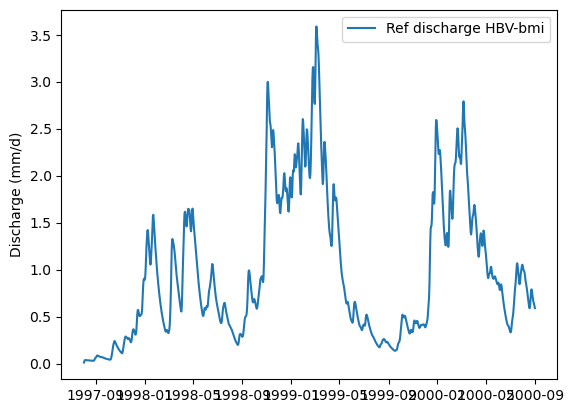

In [16]:
fig, ax = plt.subplots(1,1)
#df.plot(ax=ax, label="Modeled discharge HBV-bmi")
plt.plot(time, Q_ref[1:], label="Ref discharge HBV-bmi")
ax.set_ylabel('Discharge (mm/d)')
ax.legend(bbox_to_anchor=(1,1))

## 2. Check whether your code is correct

If the above looks reasonable, you probably have a good implementation of HBV. We can test if your HBV works as intended by running it through a scenario with pre-determined inital conditions and parameters. If the cells below can run without any assertions or erros, your model most likely works as intended. These kind of test are often used in software engineering to test if code behaves as intended. 

To test your HBV model, run the next cell. This is an example with different parameters and initial storages, to see if your implemented function works properly. 

In this example, the interception storage is filled with 15 mm of water and the unsaturated rootzone storage is initally set to 60 mm. The other storages are empty at the initial state. By using the parameter set given below, the water will divide over the other storages. Have a look at the chosen initial conditions and parameters. You should be able to calculate by hand what the storages are supposed to be after one timestep.

The ```assert``` lines test if your HBV does indeed give the expected results.

In [17]:
forcing_test = HBVForcing(start_time = experiment_start_date,
                          end_time = experiment_end_date,
                          directory = forcing_path,
                          camels_file = f'Forcing_test.txt',
                          test_data_bool = True
                          )

model_test = HBV(forcing=forcing_test)

param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]
parameters_test = np.array([5,   0.35,  100,    1,   20,   5,     0.1,  0.4])

S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]
initial_storage_test = np.array([15,  60,  0,  0])


config_file_test, _ = model_test.setup(
                            parameters=','.join([str(p) for p in parameters_test]),
                            initial_storage=','.join([str(s) for s in initial_storage_test]),
                               )
model_test.initialize(config_file_test)

model_test.update()


assert np.isclose(model_test.get_value('Pe_dt'), 25, rtol=1e-4, atol=1e-4)
assert np.isclose(model_test.get_value('Ei_dt'), 0, rtol=1e-4, atol=1e-4)
assert np.isclose(model_test.get_value('Ea_dt'), 20, rtol=1e-4, atol=1e-4)

assert np.isclose(model_test.get_value('Si'), 5, rtol=1e-4, atol=1e-4)
assert np.isclose(model_test.get_value('Sf'), 13.5, rtol=1e-4, atol=1e-4)
assert np.isclose(model_test.get_value('Su'), 40, rtol=1e-4, atol=1e-4)
assert np.isclose(model_test.get_value('Ss'), 6, rtol=1e-4, atol=1e-4)

assert np.isclose(model_test.get_value("Qus_dt"), 10, rtol=1e-4, atol=1e-4)
assert np.isclose(model_test.get_value('Qf_dt'), 1.5, rtol=1e-4, atol=1e-4)
assert np.isclose(model_test.get_value('Qs_dt'), 4, rtol=1e-4, atol=1e-4)

model_test.finalize()

## 3. Create your own test (optionally)

You can also create a test case yourself. In the code cell below, a structure is made to create your own test case. In the first cell, you have to choose initial parameters and initial storages. With these input parametes you can calculate the outcome values after one timestep by hand. Fill in these values at the designated location in the first cell. You need to run the second cell to see if you correctly created a test case. If it does not raise an assertion, you succeeded. 
If an assertion raises and this did not raise in the predefined test case, you probably made an error in your hand calculations. 

For the first timestep, the precipitation and potential evaporation are equal to **15 mm and 10 mm** respectively. Use these in your hand-calculations. In the HBV model, it is automatically read from the ```Forcing_test.txt``` file.



In [18]:
def own_test():
    forcing_test = HBVForcing(start_time = experiment_start_date,
                              end_time = experiment_end_date,
                              directory = forcing_path,
                              camels_file = f'Forcing_test.txt',
                              test_data_bool = True
                              )
    
    model_test_own = HBV(forcing=forcing_test)
    
    param_names = ["Imax","Ce",  "Sumax", "beta",  "Pmax",  "Tlag",   "Kf",   "Ks"]
    parameters_test = np.array([0,0,0,0,0,0,0,0])  # choose parameters yourself 
    
    S_names = ["Interception storage", "Unsaturated Rootzone Storage", "Fastflow storage", "Groundwater storage"]
    initial_storage_test = np.array([0,0,0,0])  # choose the initial storages yourself
    
    config_file_test, _ = model_test_own.setup(
                                parameters=','.join([str(p) for p in parameters_test]),
                                initial_storage=','.join([str(s) for s in initial_storage_test]),
                                   )
    model_test_own.initialize(config_file_test)
    
    model_test_own.update()

    # Fill in the values that occur after one timestep
    Pe = 0
    Ei = 0
    Ea = 0
    Si = 0
    Sf = 0
    Su = 0
    Ss = 0
    Qus_dt = 0
    Qf_dt = 0
    Qs_dt = 0
    
    ans_list = [Pe, Ei, Ea, Si, Sf, Su, Ss, Qus_dt, Qf_dt, Qs_dt]
    model_test_own.finalize()

    return ans_list

In [19]:
answer = own_test()

### BEGIN HIDDEN TESTS
def check(list):

    Pe = list[0]
    Ei = list[1]
    Ea = list[2]
    Si = list[3]
    Sf = list[4]
    Su = list[5]
    Ss = list[6]
    Qus_dt = list[7]
    Qf_dt = list[8]
    Qs_dt = list[9]
    
    
    assert np.isclose(Pe, 0, rtol=1e-4, atol=1e-4)
    assert np.isclose(Ei, 0, rtol=1e-4, atol=1e-4)
    assert np.isclose(Ea, 0, rtol=1e-4, atol=1e-4)
    
    assert np.isclose(Si, 0, rtol=1e-4, atol=1e-4)
    assert np.isclose(Sf, 0, rtol=1e-4, atol=1e-4)
    assert np.isclose(Su, 0, rtol=1e-4, atol=1e-4)
    assert np.isclose(Ss, 0, rtol=1e-4, atol=1e-4)
    
    assert np.isclose(Qus_dt, 0, rtol=1e-4, atol=1e-4)
    assert np.isclose(Qf_dt, 0, rtol=1e-4, atol=1e-4)
    assert np.isclose(Qs_dt, 0, rtol=1e-4, atol=1e-4)
### END HIDDEN TESTS

check(answer)

/home/group4/teaching-materials/book/2_modelling_advanced_ewatercycle/hbv_bmi.py:116: RuntimeWarning: invalid value encountered in scalar divide
/home/group4/teaching-materials/book/2_modelling_advanced_ewatercycle/hbv_bmi.py:125: RuntimeWarning: invalid value encountered in scalar divide
/home/group4/teaching-materials/book/2_modelling_advanced_ewatercycle/hbv_bmi.py:130: RuntimeWarning: invalid value encountered in scalar divide
